In [ ]:
import pandas as pd

# Leer CSV con precaución por columnas mixtas
df = pd.read_csv("city_temperature.csv", low_memory=False)

# Ver columnas y primeras filas
print(df.columns)
df.head()

Index(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year',
       'AvgTemperature'],
      dtype='object')


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [ ]:
# Filtrar datos solo para la ciudad de Algiers, en Algeria
df_algiers = df[(df['City'] == 'Algiers') & (df['Country'] == 'Algeria')]

# Eliminar temperaturas inválidas (-99 es un valor de error en el dataset)
df_algiers = df_algiers[df_algiers['AvgTemperature'] != -99]

# Crear una nueva columna de fecha combinando Año, Mes y Día
df_algiers['Date'] = pd.to_datetime(df_algiers[['Year', 'Month', 'Day']])

# Seleccionar solo las columnas necesarias y ordenarlas por fecha
df_algiers = df_algiers[['Date', 'AvgTemperature']].sort_values('Date')

# Renombrar columna a "Temperature" y establecer "Date" como índice
df_algiers = df_algiers.rename(columns={'AvgTemperature': 'Temperature'})
df_algiers = df_algiers.set_index('Date')

# Verificar estructura final del DataFrame
df_algiers.head()

,Temperature
Date,
1995-01-01,64.2
1995-01-02,49.4
1995-01-03,48.8
1995-01-04,46.4
1995-01-05,47.9


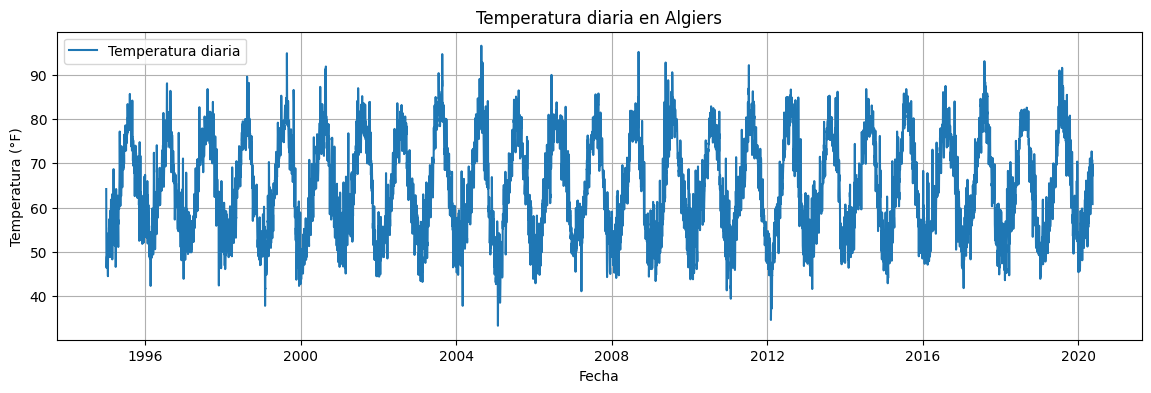

In [ ]:
import matplotlib.pyplot as plt

# Graficar la serie de temperatura diaria
plt.figure(figsize=(14, 4))
plt.plot(df_algiers['Temperature'], label='Temperatura diaria')
plt.title('Temperatura diaria en Algiers')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.grid(True)
plt.show()

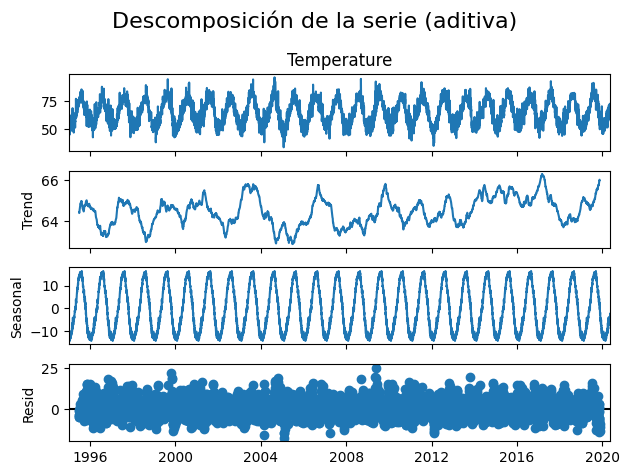

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición aditiva (asume tendencia + estacionalidad + residuo)
resultado = seasonal_decompose(df_algiers['Temperature'], model='additive', period=365)

# Mostrar los componentes de la descomposición
resultado.plot()
plt.suptitle("Descomposición de la serie (aditiva)", fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

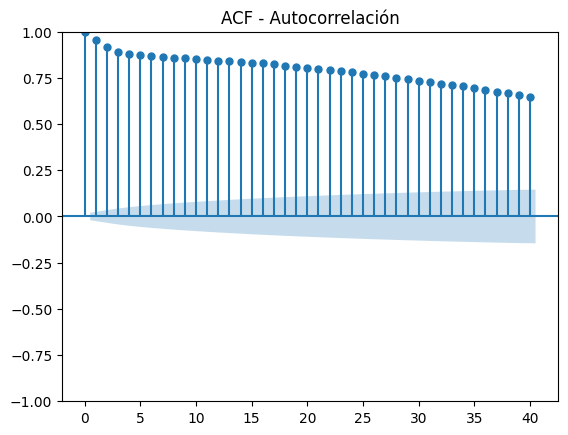

<Figure size 1000x400 with 0 Axes>

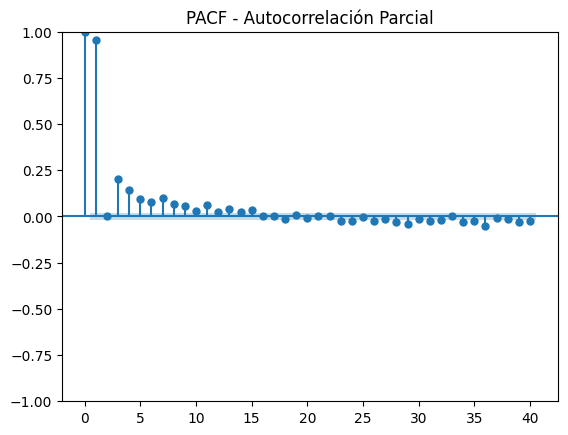

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF - Autocorrelación
plt.figure(figsize=(10, 4))
plot_acf(df_algiers['Temperature'].dropna(), lags=40)
plt.title("ACF - Autocorrelación")
plt.show()

# PACF - Autocorrelación Parcial
plt.figure(figsize=(10, 4))
plot_pacf(df_algiers['Temperature'].dropna(), lags=40)
plt.title("PACF - Autocorrelación Parcial")
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 9231
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -23429.534
Date:                Sat, 21 Jun 2025   AIC                          46865.068
Time:                        19:38:26   BIC                          46886.459
Sample:                             0   HQIC                         46872.338
                               - 9231                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6529      0.013     49.923      0.000       0.627       0.679
ma.L1         -0.8814      0.009    -97.269      0.000      -0.899      -0.864
sigma2         9.3829      0.096     97.857      0.0

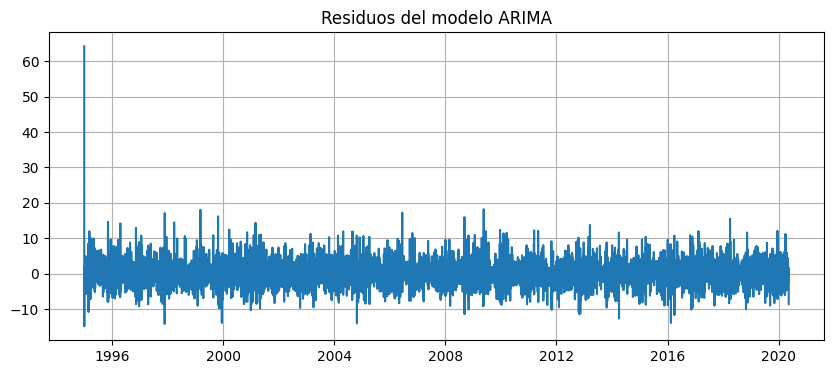

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Modelo ARIMA: (1,1,1) como ejemplo
modelo_arima = ARIMA(df_algiers['Temperature'], order=(1, 1, 1))
resultado_arima = modelo_arima.fit()

# Mostrar resumen del modelo ARIMA
print(resultado_arima.summary())

# Graficar residuos del modelo ARIMA
residuales = resultado_arima.resid
plt.figure(figsize=(10, 4))
plt.plot(residuales)
plt.title('Residuos del modelo ARIMA')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


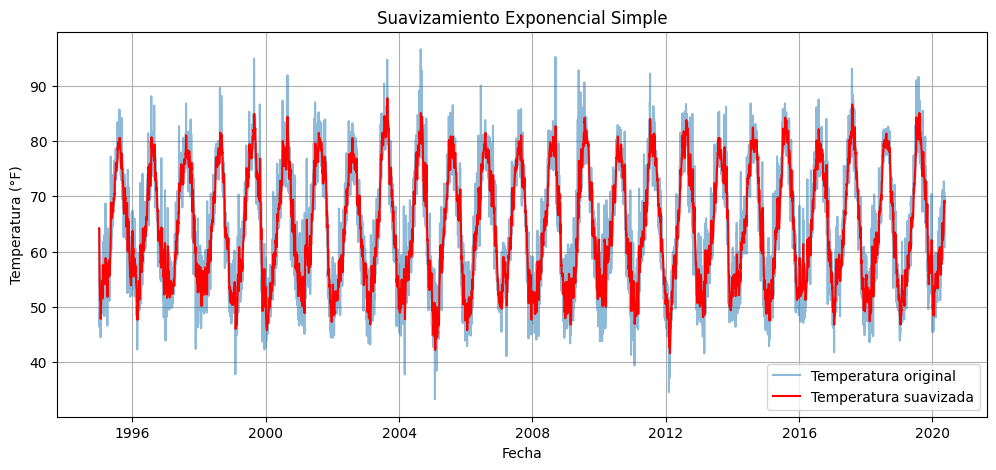

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Aplicar suavizamiento exponencial simple
model = SimpleExpSmoothing(df_algiers['Temperature']).fit(smoothing_level=0.2, optimized=False)
df_algiers['Smoothed'] = model.fittedvalues

# Graficar la serie original y suavizada
plt.figure(figsize=(12, 5))
plt.plot(df_algiers['Temperature'], label='Temperatura original', alpha=0.5)
plt.plot(df_algiers['Smoothed'], label='Temperatura suavizada', color='red')
plt.title('Suavizamiento Exponencial Simple')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.grid(True)
plt.show()

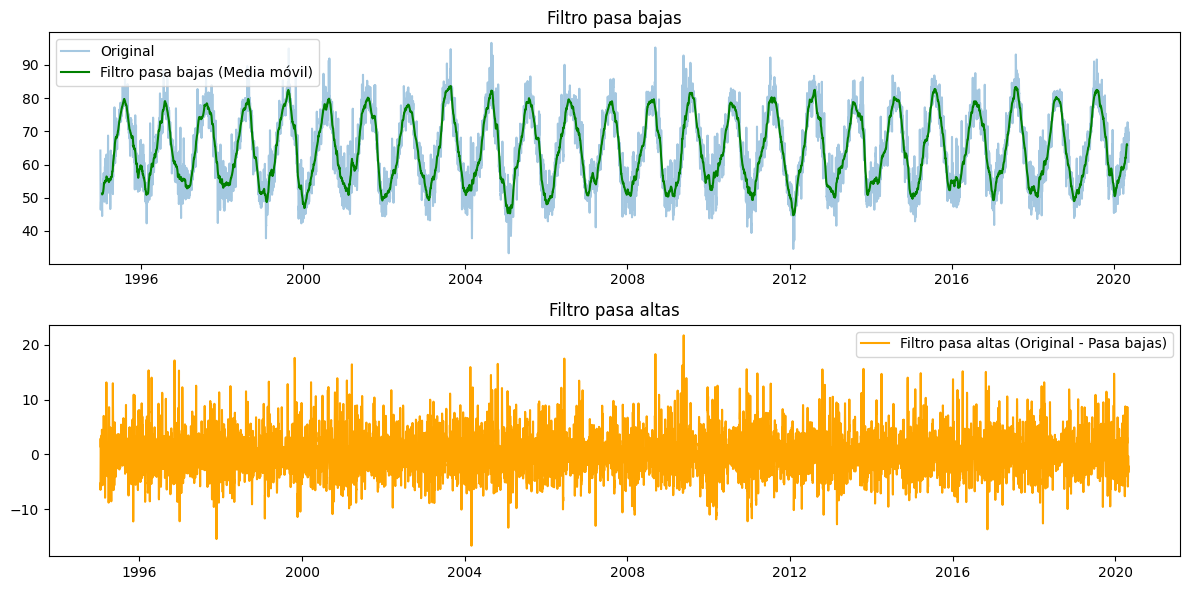

In [ ]:
# Filtro pasa bajas con media móvil (ventana de 30 días)
df_algiers['LowPass'] = df_algiers['Temperature'].rolling(window=30, center=True).mean()

# Filtro pasa altas (residuo entre original y pasa bajas)
df_algiers['HighPass'] = df_algiers['Temperature'] - df_algiers['LowPass']

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Pasa bajas
plt.subplot(2, 1, 1)
plt.plot(df_algiers['Temperature'], label='Original', alpha=0.4)
plt.plot(df_algiers['LowPass'], label='Filtro pasa bajas (Media móvil)', color='green')
plt.title('Filtro pasa bajas')
plt.legend()

# Pasa altas
plt.subplot(2, 1, 2)
plt.plot(df_algiers['HighPass'], label='Filtro pasa altas (Original - Pasa bajas)', color='orange')
plt.title('Filtro pasa altas')
plt.legend()

plt.tight_layout()
plt.show()

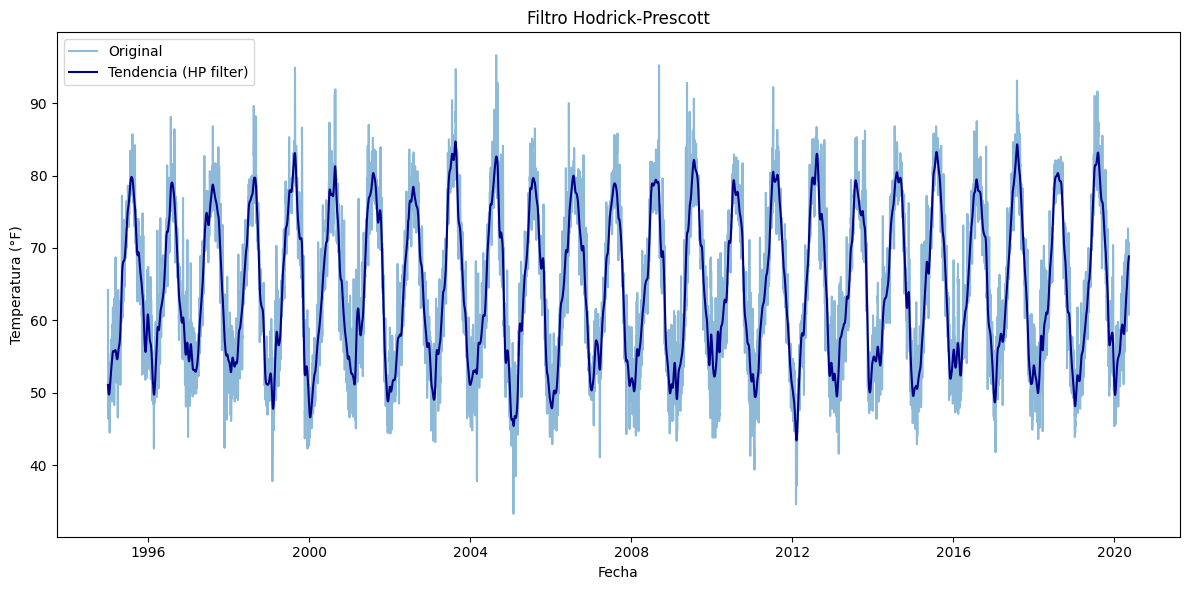

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Aplicar el filtro Hodrick-Prescott
cycle, trend = hpfilter(df_algiers['Temperature'], lamb=1600)

# Agregar los resultados al DataFrame
df_algiers['HP_Trend'] = trend
df_algiers['HP_Cycle'] = cycle

# Graficar la serie original junto con la tendencia y el ciclo
plt.figure(figsize=(12, 6))

plt.plot(df_algiers['Temperature'], label='Original', alpha=0.5)
plt.plot(df_algiers['HP_Trend'], label='Tendencia (HP filter)', color='darkblue')
plt.title('Filtro Hodrick-Prescott')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.tight_layout()
plt.show()

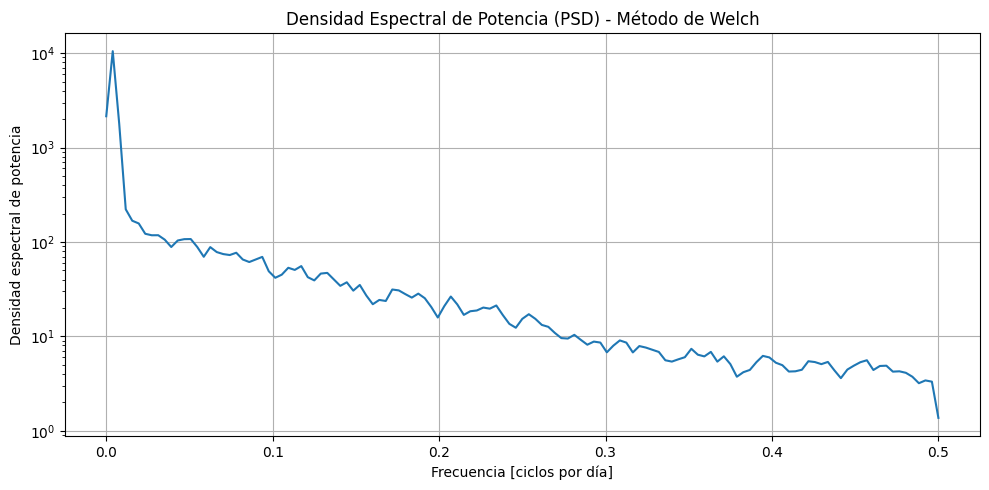

In [ ]:
from scipy.signal import welch

# Calcular la densidad espectral de potencia usando el método de Welch
freqs, psd = welch(df_algiers['Temperature'].dropna(), fs=1)  # fs=1 porque los datos son diarios

# Graficar la densidad espectral de potencia
plt.figure(figsize=(10, 5))
plt.semilogy(freqs, psd)
plt.title('Densidad Espectral de Potencia (PSD) - Método de Welch')
plt.xlabel('Frecuencia [ciclos por día]')
plt.ylabel('Densidad espectral de potencia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Conclusión general
print("\nConclusión general:")
print("""
En esta práctica, hemos analizado una serie temporal de temperaturas diarias en la ciudad de Algiers,
aplicando diversas técnicas de análisis de series de tiempo. Primero, hemos preprocesado los datos,
eliminando valores inválidos y creando un formato adecuado para el análisis.

A través de la descomposición estacional, hemos podido separar las componentes de la serie temporal
(tendencia, estacionalidad y residuo), lo que nos permitió observar los patrones subyacentes en los datos.
El uso del modelo ARIMA nos permitió ajustar un modelo que captura las dependencias temporales en los datos
y evaluar los residuos para verificar la calidad del ajuste.

Los filtros aplicados, como el suavizamiento exponencial y los filtros pasa bajas y pasa altas, ayudaron a suavizar
y descomponer las fluctuaciones en la serie temporal, facilitando la identificación de patrones de largo plazo y
variaciones más recientes.

Finalmente, el filtro Hodrick-Prescott fue útil para separar la tendencia de los ciclos, y la densidad espectral
de potencia (PSD) nos permitió estudiar las frecuencias dominantes en la serie temporal, identificando patrones cíclicos.

En conjunto, estas técnicas proporcionan una visión detallada de los datos y permiten tomar decisiones más informadas
en el análisis de series temporales. La práctica también destaca la importancia de seleccionar las herramientas adecuadas
para cada tipo de comportamiento que se desee modelar en los datos de series temporales.
""")


Conclusión general:

En esta práctica, hemos analizado una serie temporal de temperaturas diarias en la ciudad de Algiers,
aplicando diversas técnicas de análisis de series de tiempo. Primero, hemos preprocesado los datos,
eliminando valores inválidos y creando un formato adecuado para el análisis.

A través de la descomposición estacional, hemos podido separar las componentes de la serie temporal
(tendencia, estacionalidad y residuo), lo que nos permitió observar los patrones subyacentes en los datos.
El uso del modelo ARIMA nos permitió ajustar un modelo que captura las dependencias temporales en los datos
y evaluar los residuos para verificar la calidad del ajuste.

Los filtros aplicados, como el suavizamiento exponencial y los filtros pasa bajas y pasa altas, ayudaron a suavizar
y descomponer las fluctuaciones en la serie temporal, facilitando la identificación de patrones de largo plazo y
variaciones más recientes.

Finalmente, el filtro Hodrick-Prescott fue útil para separar la 